In [17]:
import pandas as pd
import pandas_ta as ta
import pandas as pd
import numpy as np
import random



candlestick_frame = 12
pnl_threshold = 3

df = pd.read_csv('../../data/ETHUSDT-ohlcv.csv')
# try:
#     df.ta.strategy("all")
# except Exception as e:
#     print(e)
df['LOGRET_1'] = list(df.ta.log_return())
# df['NATR_14'] = list(df.ta.natr(length=14))
# df['SLOPE_1'] = list(df.ta.slope())


ts = list(df['time'])
open = list(df['open'])
high = list(df['high'])
low = list(df['low'])
close = list(df['close'])
volume = list(df['volume'])
tot = len(ts)
long_runup_lst = []
long_drawdown_lst = []
short_runup_lst = []
short_drawdown_lst = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        max_high = max(high[idx+1:idx+candlestick_frame])
        min_low = min(low[idx+1:idx+candlestick_frame])
        entry_price = open[idx+1]
        long_runup_lst.append(round((max_high*100/entry_price)-100, 6))
        long_drawdown_lst.append(round((min_low*100/entry_price)-100, 6))
        short_runup_lst.append(round((entry_price*100/min_low)-100, 6))
        short_drawdown_lst.append(round((entry_price*100/max_high)-100, 6))
    else:
        long_runup_lst.append(0)
        long_drawdown_lst.append(0)
        short_runup_lst.append(0)
        short_drawdown_lst.append(0)     


long=[]
short=[]
dont_trade=[]
signal = []

for idx in range(tot):
    if (idx >= candlestick_frame) and (idx <= tot - candlestick_frame):
        if long_runup_lst[idx] >= pnl_threshold:
            signal.append('long')
        elif short_runup_lst[idx] >= pnl_threshold:
            signal.append('short')
        else:
            signal.append('dont_trade')
    else:
        signal.append('dont_trade')


df['signal'] = signal

# long_indices = df[df['signal'].str.contains('long', case=False)].index
# short_indices = df[df['signal'].str.contains('short', case=False)].index
# dont_trade_indices = list(df[df['signal'].str.contains('dont_trade', case=False)].index)
# num_indices_to_pick  = len(dont_trade_indices) - min([len(long_indices), len(short_indices)])
# random_indices = random.sample(dont_trade_indices, num_indices_to_pick)
# df = df.drop(random_indices)

# df.reset_index(drop=True, inplace=True)

df = df.drop(columns = ['time', 'open', 'high', 'low', 'close', 'volume'], axis=1)

# print('saving dataset.csv....')
# dataset_fn = f'../../data/dataset.csv'
# pd.DataFrame(df).to_csv(dataset_fn, index=False)

# print('before nan drop', len(df))
# # df = df.dropna()
# print('after nan drop', len(df))
df

,LOGRET_1,signal
0,NaN,dont_trade
1,-0.001034,dont_trade
2,0.000391,dont_trade
3,0.005098,dont_trade
4,-0.001501,dont_trade
...,...,...
20540,0.000933,dont_trade
20541,-0.000300,dont_trade
20542,0.001590,dont_trade
20543,0.000399,dont_trade


In [29]:
df.to_csv(f'../../data/tdf.csv', index=False)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1


[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Description,Value
0,Session id,123
1,Target,signal
2,Target type,Multiclass
3,Target mapping,"dont_trade: 0, long: 1, short: 2"
4,Original data shape,"(20545, 2)"
5,Transformed data shape,"(20545, 2)"
6,Transformed train set shape,"(14381, 2)"
7,Transformed test set shape,"(6164, 2)"
8,Numeric features,1
9,Rows with missing values,0.0%


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Using sparse features with CUDA is currently not supported.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset migh

[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1
[LightGBM] [Fatal] CUDA Tree Learner was not enabled in this build.
Please recompile with CMake option -DUSE_CUDAP=1


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8610,0.6387,0.8610,0.7697,0.7996,0.0195,0.0664
1,0.8602,0.5922,0.8602,0.7608,0.7999,0.0212,0.0579
2,0.8616,0.6409,0.8616,0.7705,0.8004,0.0196,0.0667
3,0.8595,0.6433,0.8595,0.7421,0.7965,-0.0031,-0.0133
4,0.8616,0.5927,0.8616,0.7424,0.7976,0.0000,0.0000
5,0.8609,0.6570,0.8609,0.7650,0.7985,0.0069,0.0300
6,0.8588,0.6301,0.8588,0.7519,0.7974,0.0124,0.0362
7,0.8595,0.6211,0.8595,0.7574,0.7995,0.0285,0.0704
8,0.8609,0.6259,0.8609,0.7412,0.7966,0.0000,0.0000


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

Transformation Pipeline and Model Successfully Saved
combined_model model saved. accuracy_mean=0.8605


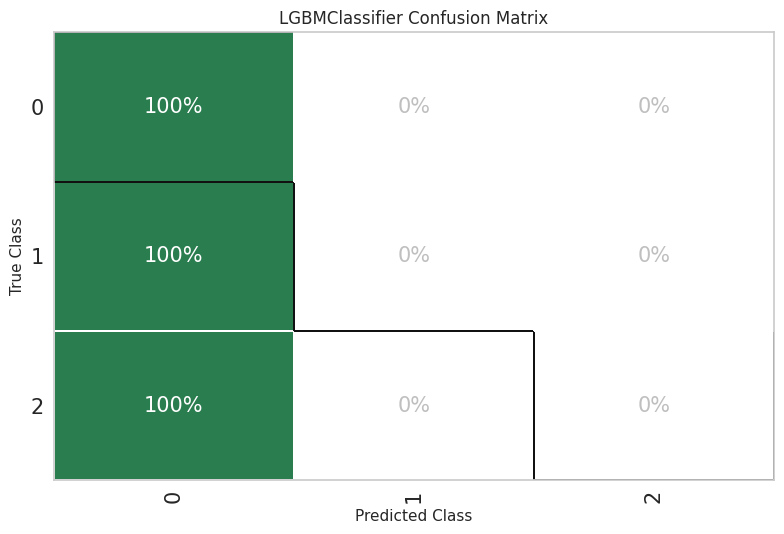

In [18]:


from pycaret.classification import load_model, predict_model
from pycaret.classification import *
from pycaret.classification import ClassificationExperiment
from lightgbm import LGBMClassifier
import numpy as np


exp = ClassificationExperiment()
dataset_path = '../../data/'
# data = pd.read_csv(f'{dataset_path}combined_dataset.csv')
# data.replace([np.inf, -np.inf], np.nan, inplace=True)
s = setup(df, target = 'signal', session_id = 123, use_gpu=True)
model = create_model(LGBMClassifier())
validation_scores = pull()
accuracy_mean = validation_scores['Accuracy']['Mean']

# save pipeline
model_name = 'combined_model'
save_model(model, f'../../models/{model_name}-{accuracy_mean}')
print(f'{model_name} model saved. accuracy_mean={accuracy_mean}')
plot_model(model, plot = 'confusion_matrix', plot_kwargs = {'percent': True})